<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:140 px; height:140px;">
<img src="https://cloudrun.co/img/logo_noname.png" alt="Cloudrun Logo" style="height: 140px;">
</div>

<h1>Step 3: Analysis</h1>
<h2>By Kayla Besong</h2>

This notebook is designed to plot and generate statistical analysis to compare previously downloaded GFS, NAM, Cloudrun, and observational data from Pensecola Airport. It has two parts, the first plotting data for all model runs against observations and the second, to generate formal statistics with additional supplementary plots. 

<div style="clear:both"></div>
</div>

In [1]:
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import scipy
import xarray as xr

# Read data

## Observational data -- Pre-downloaded from NCEP for Pensacola International Airport

In [2]:
# Open observational dataset, received in CSV format, using pandas
obs_orginal = pd.read_csv('Pensacola_airport_201911.csv')

In [3]:
# Convert pandas datetime index to numpy datetime64 
obs_time = obs_orginal.DATE.to_numpy().astype('datetime64') + (3600 * 6)

In [4]:
# Generate dataset with exact variable names as Cloudrun to ease plotting and allow for unit conversion.
obs = xr.Dataset({
    'wind_speed': (['time'], (pd.to_numeric(obs_orginal['HourlyWindSpeed'], errors = 'coerce').values) * 0.44704),
    'wind_dir': (['time'], pd.to_numeric(obs_orginal['HourlyWindDirection'], errors='coerce').values),
    'air_pressure_at_mean_sea_level': (['time'], (pd.to_numeric(obs_orginal['HourlySeaLevelPressure'], errors = 'coerce').values)*33.8639),
    'air_temperature_2m': (['time'],((pd.to_numeric(obs_orginal['HourlyDryBulbTemperature'], errors = 'coerce').values - 32) * (5/9.))),
    'relative_humidity_2m': (['time'], pd.to_numeric(obs_orginal['HourlyRelativeHumidity'], errors = 'coerce').values),
    'rainfall_amount': (['time'], pd.to_numeric(obs_orginal['HourlyPrecipitation'], errors = 'coerce').values * 25.40)
    },             
    coords = {'time': obs_time}
)

print(obs)

<xarray.Dataset>
Dimensions:                         (time: 585)
Coordinates:
  * time                            (time) datetime64[ns] 2019-11-11T06:53:00...
Data variables:
    wind_speed                      (time) float64 2.235 2.682 2.682 ... nan nan
    wind_dir                        (time) float64 50.0 60.0 50.0 ... nan nan
    air_pressure_at_mean_sea_level  (time) float64 1.02e+03 1.019e+03 ... nan
    air_temperature_2m              (time) float64 13.33 12.78 12.78 ... nan nan
    relative_humidity_2m            (time) float64 87.0 83.0 80.0 ... nan nan
    rainfall_amount                 (time) float64 0.0 0.0 0.0 ... 0.0 nan nan


In [5]:
# Cloudrun data time window
obs = obs.sel(time = slice(obs.time[0], '2019-11-29T23:53:00'))

In [6]:
# Rainfall accumulation 
for i in range(1, len(obs)):
    obs['rainfall_amount'][i] = obs['rainfall_amount'][i] - obs['rainfall_amount'][i-1]

## Cloudrun model output -- Pre-downloaded

In [7]:
cloud_dir = "data/" # path to pre-downloaded Cloudrun data
gfs_dir = "processed_ncei/GFS/"
nam_dir = "processed_ncei/NAM/"

In [8]:
# Find nearest Cloudrun grid point to the Pensacola Airport 
lat = 30.47806
lon = -87.18694

ds = xr.open_dataset(cloud_dir + 'PNS_2019111100/cloudrun_d01_2019-11-11_00:00:00.nc')

abslat = np.abs(ds.latitude - lat)
abslon = np.abs(ds.longitude - lon)
c = np.maximum(abslon, abslat)
yloc, xloc = np.where(c == np.min(c))   

In [9]:
xloc[0], yloc[0], ds.latitude[yloc[0], xloc[0]], ds.longitude[yloc[0], xloc[0]], c.shape

(92,
 64,
 <xarray.DataArray 'latitude' ()>
 array(30.4791, dtype=float32)
 Coordinates:
     x        float64 1.05e+04
     y        float64 4.001e+03
 Attributes:
     standard_name:  latitude
     long_name:      latitude
     units:          degrees_north
     grid_mapping:   Lambert_Conformal,
 <xarray.DataArray 'longitude' ()>
 array(-87.18936, dtype=float32)
 Coordinates:
     x        float64 1.05e+04
     y        float64 4.001e+03
 Attributes:
     standard_name:  longitude
     long_name:      longitude
     units:          degrees_east
     grid_mapping:   Lambert_Conformal,
 (121, 164))

In [10]:
%%time
# cr is a nested list of each 72-hour run so len(r)  number of runs (in this case, 32) 
## with each sublist == 29 for 72/3days = 24 hours + additional overlap from last 5 non-overlapping hours 
cr = []
for root, dirs, files in sorted(os.walk(cloud_dir)): # traverse directories
    print('reading ' + root )
    datas = []
    for file in sorted(files):
        if file[-2:] == 'nc':
            datas.append(xr.open_dataset(root + '/' + file).isel(x=xloc[0], y=yloc[0]))
        else:
            continue
            
    # append only non-empty list of data files
    if len(datas) > 0:                      
        cr.append(xr.concat(datas, dim='time'))
    else:
        continue     

reading data/
reading data/PNS_2019111100
reading data/PNS_2019111112
reading data/PNS_2019111200
reading data/PNS_2019111212
reading data/PNS_2019111300
reading data/PNS_2019111312
reading data/PNS_2019111400
reading data/PNS_2019111412
reading data/PNS_2019111500
reading data/PNS_2019111512
reading data/PNS_2019111600
reading data/PNS_2019111612
reading data/PNS_2019111700
reading data/PNS_2019111712
reading data/PNS_2019111800
reading data/PNS_2019111812
reading data/PNS_2019111900
reading data/PNS_2019111912
reading data/PNS_2019112000
reading data/PNS_2019112012
reading data/PNS_2019112100
reading data/PNS_2019112112
reading data/PNS_2019112200
reading data/PNS_2019112212
reading data/PNS_2019112300
reading data/PNS_2019112312
reading data/PNS_2019112400
reading data/PNS_2019112412
reading data/PNS_2019112500
reading data/PNS_2019112512
reading data/PNS_2019112600
reading data/PNS_2019112612
CPU times: user 3min 48s, sys: 9.33 s, total: 3min 57s
Wall time: 4min 11s


## Read GFS data

In [11]:
gfs = []
for file in sorted(os.listdir(gfs_dir)):
    if file[-2:] == 'nc':
        gfs_temp = xr.open_dataset(gfs_dir + file)
        if len(gfs_temp.time) < 25:
            print('Incomplete model run for: ', file)
        else:
            gfs.append(gfs_temp)

## Read NAM data

In [12]:
nam = []
for file in sorted(os.listdir(nam_dir)):
    if file[-2:] == 'nc':    
        nam_temp = xr.open_dataset(nam_dir + file)
        if len(nam_temp.time) < 25:
            print('Incomplete model run for: ', file)
        else:
            nam.append(nam_temp)

## Convert all Cloudrun variables to the same units as observational data

In [13]:
for i in range(len(cr)):
    cr[i]['wind_speed'] = np.sqrt(cr[i]['x_wind_10m']**2 + cr[i]['y_wind_10m']**2)                                           
    cr[i]['air_pressure_at_mean_sea_level'] /= 100.
    cr[i]['air_temperature_2m'] -= 273.15
    wind_dir1 = np.arctan2(- cr[i]['x_wind_10m'].values, - cr[i]['y_wind_10m'].values) * 180. / np.pi
    wind_dir1[np.where(wind_dir1 < 0)] += 360
    cr[i]['wind_dir'] = xr.DataArray(wind_dir1, coords=[('time', cr[i].time.values)])   
    rain_array = cr[i]['rainfall_amount'].values[1:] - cr[i]['rainfall_amount'].values[:-1]
    cr[i]['rainfall_amount'] = xr.DataArray(rain_array, coords = [('time', cr[i].time.values[1:])])

In [14]:
variables = [
    'wind_speed',
    'wind_dir',
    'air_pressure_at_mean_sea_level',
    'air_temperature_2m',
    'relative_humidity_2m',
    'rainfall_amount'
]

# Plot data

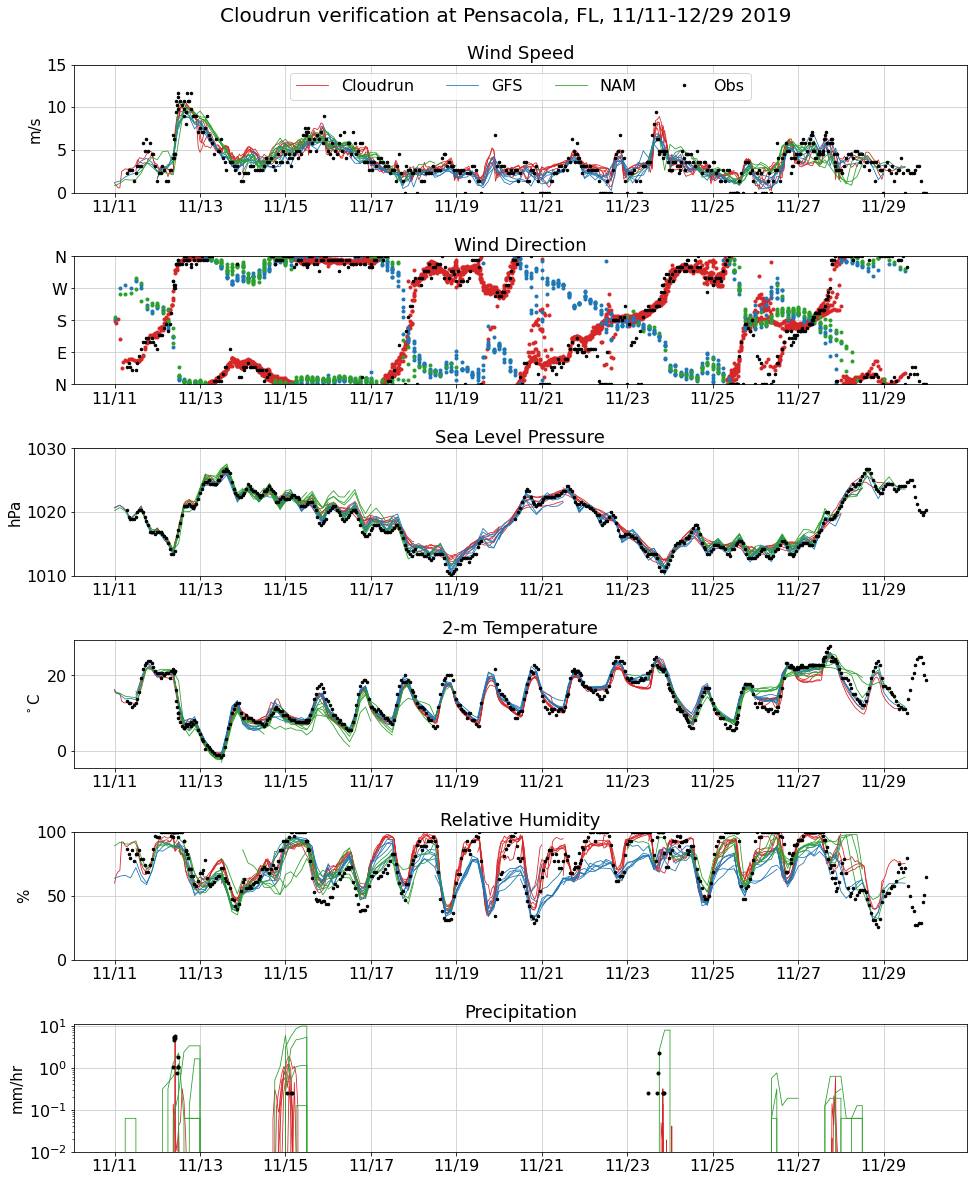

In [15]:
LINEWIDTH = 0.8

fig, axes = plt.subplots(6, 1, figsize=(16, 20))

# subplot titles
titles = [
    'Wind Speed',
    'Wind Direction',
    'Sea Level Pressure',
    '2-m Temperature',
    'Relative Humidity',
    'Precipitation'
]

ylabels_ = ['m/s', ' ', 'hPa', '$^\circ$C', '%', 'mm/hr']                                                                        ## y axis labels, variable units 
myFmt = mdates.DateFormatter('%m/%d')                                                                                        ## matplotlib data formatter for x-axis data labels 

ax = axes.ravel()

for n in range(len(variables)):
    
    # special rainfall insert     
    if variables[n] == 'rainfall_amount':
        
        for i in range(len(cr)):
            ax[n].semilogy(cr[i].time, cr[i][variables[n]], c='tab:red', lw=LINEWIDTH)
        
        for i in range(len(gfs)):
            ax[n].semilogy(gfs[i].time, gfs[i][variables[n]], c='tab:blue', lw=LINEWIDTH)
            
        for i in range(len(nam)):
            ax[n].semilogy(nam[i].time, nam[i][variables[n]], c='tab:green', lw=LINEWIDTH)
            
        ax[n].semilogy(obs.time, obs[variables[n]], 'k.', ms=6)
        ax[n].set_ylim([1e-2, 1.1e1])
        
    else:
    
        for i in range(len(cr)):
            ax[n].plot(cr[i].time, cr[i][variables[n]], c='tab:red', lw=0 if variables[n] == 'wind_dir' else LINEWIDTH, 
                   marker = '.' if variables[n] == 'wind_dir' else None, label='Cloudrun' if i == 0 else None)

        for i in range(len(gfs)):
            ax[n].plot(gfs[i].time, gfs[i][variables[n]], c='tab:blue', lw=0 if variables[n] == 'wind_dir' else LINEWIDTH, 
                   marker = '.' if variables[n] == 'wind_dir' else None, label='GFS' if i == 0 else None)

        for i in range(len(nam)):
            ax[n].plot(nam[i].time, nam[i][variables[n]], c='tab:green', lw=0 if variables[n] == 'wind_dir' else LINEWIDTH, 
                   marker = '.' if variables[n] == 'wind_dir' else None, label='NAM' if i == 0 else None)

        ax[n].plot(obs.time, obs[variables[n]], 'k.', ms=5, label = 'Obs' if n == 0 else None)

    ax[n].set_title(titles[n], fontsize = 18)
    ax[n].xaxis.set_major_formatter(myFmt)
    ax[n].set_ylabel(ylabels_[n], fontsize = 15)
    ax[n].grid(c='0.8')
    ax[n].tick_params(labelsize=16)
    
    if variables[n] == 'wind_dir':
        ax[n].set_ylim(0, 360)
        ax[n].set_yticks([0, 90, 180, 270, 360])
        ax[n].set_yticklabels(['N', 'E', 'S', 'W', 'N'])

ax[0].set_ylim(0, 15)
ax[2].set_ylim(1010, 1030)
ax[4].set_ylim(0, 100)

handles, labels = ax[0].get_legend_handles_labels()    
ax[0].legend(handles, labels, loc='upper center', ncol=4, prop={'size': 16})
plt.subplots_adjust(hspace=0.5)
fig.suptitle('Cloudrun verification at Pensacola, FL, 11/11-12/29 2019', fontsize=20, y =.92)
plt.savefig('cloudrun_pensacola_timeseries.png', dpi=300, facecolor='white', bbox_inches='tight')

# Statistics on Data

In [16]:
def wind_dir_error(wd_mod, wd_obs):
    """Returns the wind direction bias and absolute bias
    given wind direction from model and observations."""
    u_mod, v_mod = np.cos(wd_mod), np.sin(wd_mod)
    u_obs, v_obs = np.cos(wd_obs), np.sin(wd_obs)

    du_bias = u_mod - u_obs
    dv_bias = v_mod - v_obs
    
    wd_bias = np.arctan2(dv_bias, du_bias) * 180 / np.pi
    wd_ab_bias = np.arctan2(abs(dv_bias), abs(du_bias)) * 180 / np.pi
    
    return wd_bias, wd_ab_bias, du_bias, dv_bias

In [17]:
def do_statistics_init(input_mod, input_obs, variables):
    """
    Returns two dictionaries whose keys are the input variables and sub keys are the bias,
    absolute error, and RMSE of the input model relative to input obs.
    
    The first dictionary considers the errors over the runs with two arrays per key and sub key:
      1) Time array with the value of the initilized times per run;
      2) Array of values corresponding to that run.
    
    The second dictionary has one value, average over each run for each key, sub-key pair. 
    """
    error_runs_dict, error_avg_dict = {}, {}
           
    # metrics to compute
    sub_keys = ['bias', 'abs_error', 'RMSE']
    for n in range(len(variables)): # dictionaries are filled by variable 

        sub_dict = {}
        sub_avg_dict = {}
        bias = []
        ab_bias = []
        RMSE = []
        x_times = []

        for i in range(len(input_mod)):
            
            ## select the observation times and variables for corresponding model times
            mod_sub = input_mod[i][variables[n]]    
            obs_sub = input_obs[variables[n]].where(input_obs[variables[n]].time == mod_sub.time, drop=True)

            if len(obs_sub) > 0:
                
                if variables[n] == 'wind_dir':

                    wd_bias, wd_ab_bias, du_bias, dv_bias = wind_dir_error(mod_sub, obs_sub)
                            
                    bias.append(float(wd_bias.mean('time').values))
                    ab_bias.append(float(wd_ab_bias.mean('time').values))

                    RMSE_u = float(np.sqrt(((du_bias)**2).mean('time').values))
                    RMSE_v = float(np.sqrt(((dv_bias)**2).mean('time').values)) 
                    
                    RMSE.append(np.arctan2(RMSE_v, RMSE_u) * (np.pi/180.))
                
                else:
                    
                    bias_c = mod_sub - obs_sub
                    
                    bias.append(float((bias_c.mean('time').values)))
                    ab_bias.append(float(np.abs(bias_c).mean('time').values))
                    RMSE.append(float(np.sqrt(((bias_c)**2).mean('time').values)))
                    
            else:

                print('The obs and model times do not align')

                bias.append(np.nan)
                ab_bias.append(np.nan)
                RMSE.append(np.nan)

            x_times.append(mod_sub.time[0].values)                     # append the times of initatilization for plotting later 

        for keys in range(0,len(sub_keys),len(sub_keys)):              # append the calculated statstical arrays to the sub dictionary according to the sub keys for the given runs 
            sub_dict[sub_keys[keys]] = [x_times,bias]
            sub_dict[sub_keys[keys+1]] = [x_times,ab_bias]
            sub_dict[sub_keys[keys+2]] = [x_times,RMSE]

            sub_avg_dict[sub_keys[keys]] = np.nanmean(bias)            # take the average of arrays for second output dictionary
            sub_avg_dict[sub_keys[keys+1]] = np.nanmean(ab_bias)
            sub_avg_dict[sub_keys[keys+2]] = np.nanmean(RMSE)

        error_runs_dict[variables[n]] = sub_dict                       # append dictionary of calculated bias, absolute error, and RMSE to larger dictionary whose key is the given variable 
        error_avg_dict[variables[n]] = sub_avg_dict
        
    return error_runs_dict, error_avg_dict

In [18]:
def do_statistics_lead(input_mod, input_obs, variables):
    """
    Compute bias, absolute error, and RMSE from input model and observation data as a function of lead time.
    The output is a nested dictionary whose keys are the input variables, and sub-keys the bias,
    absolute error, and RMSE and values arrays of these variables for a given lead time out to 72 hours
    with a step of 3. If that interval changes, the count variable (ct) will have to be altered. 
    """
    error_72_dict = {}

    for n in range(len(variables)):

        sub_dict_72 = {}
        bias_72 = []
        ab_bias_72 = []
        RMSE_72 = []
        ct = 0
        
        sub_keys = ['bias', 'abs_error', 'RMSE']

        while ct <= 24: # count to iterated over the timestep number to grab per model run 

            # sub arrays to store a given run's timestep until all runs for a timstep are appended 
            sub_bias = []
            sub_ab_bias = []
            wind_dir_u = []
            wind_dir_v = []

            for i in range(len(input_mod)):

                try: 
                    
                    mod_sub = input_mod[i][variables[n]][ct]
                    obs_sub = input_obs[variables[n]].where(input_obs[variables[n]].time == mod_sub.time, drop=True)
                    
                    if len(obs_sub) > 0:
                        if variables[n] == 'wind_dir':              # special wind direction insert 
                            wd_bias, wd_ab_bias, du_bias, dv_bias = wind_dir_error(mod_sub, obs_sub)
                            sub_bias.append(float(wd_bias.values))
                            sub_ab_bias.append(float(wd_ab_bias.values))
                            wind_dir_u.append(du_bias)
                            wind_dir_v.append(dv_bias)
                        else:
                            bias_c = mod_sub - obs_sub 
                            sub_bias.append(float((bias_c.values)))
                            sub_ab_bias.append(float(np.abs(bias_c).values))
                    else:                        
                        sub_bias.append(np.nan)
                        sub_ab_bias.append(np.nan)

                except IndexError:
                    continue
                
            ct += 1

            bias_72.append(np.nanmean(sub_bias))
            ab_bias_72.append(np.nanmean(sub_ab_bias))
            
            # second special wind direction insert for the RMSE calculation depends on the number of values being considered, N 
            if variables[n] == 'wind_dir':
                RMSE_u = float(np.sqrt(np.nanmean([u**2 for u in wind_dir_u])))
                RMSE_v = float(np.sqrt(np.nanmean([v**2 for v in wind_dir_v]))) 
                RMSE_72.append(np.arctan2(RMSE_v, RMSE_u)*(np.pi/180.))
            else:
                RMSE_72.append(float(np.sqrt(np.nanmean([i**2 for i in sub_bias]))))

        for keys in range(0,len(sub_keys),len(sub_keys)):     # append calculated statistical arrays to given keys 
            sub_dict_72[sub_keys[keys]] = bias_72
            sub_dict_72[sub_keys[keys+1]] = ab_bias_72
            sub_dict_72[sub_keys[keys+2]] = RMSE_72

        error_72_dict[variables[n]] = sub_dict_72            # append stastical sub dictionary to overarching variable based dictionary 

    return error_72_dict

## Interpolate Cloudrun values to observation times

In [19]:
cr_obs_init = []
cr_obs_lead = []

for i in range(len(cr)):
    cr_obs_init.append(cr[i].interp(time=obs.time.values).dropna(dim='time'))
    
for i in cr_obs_init:
    cr_obs_lead.append(i.resample(time='3H').mean('time'))

In [20]:
obs_mod_resamp = obs.resample(time = '3H').mean('time')

In [21]:
%%time
cr_obs_init_all, cr_obs_init_avg = do_statistics_init(cr_obs_init, obs, variables)
cr_obs_lead_out = do_statistics_lead(cr_obs_lead, obs_mod_resamp, variables)

CPU times: user 36.3 s, sys: 33.1 ms, total: 36.3 s
Wall time: 36.4 s


## GFS

In [22]:
cr_gfs_init_all, cr_gfs_init_avg = do_statistics_init(gfs, obs_mod_resamp, variables)
cr_gfs_lead_out = do_statistics_lead(gfs, obs_mod_resamp, variables)

## NAM

In [23]:
cr_nam_init_all, cr_nam_init_avg = do_statistics_init(nam, obs_mod_resamp, variables)
cr_nam_lead_out = do_statistics_lead(nam, obs_mod_resamp, variables)

# Plot Statistics Data

In [24]:
def gen_masked_vals(larger, smaller):
    """
    Function designed to 'lengthen' x-axis for missing model data to be plotted along observational data so that missing data does not have a line through it. 
    It generates a new x-axis of the longer array (designed with obs in mind) and a set of y values filled with either None or the model value. 
    The criteria for being a value over None is if the model data timestamp is within 6 hours of the observational data (which is not on the hour 12:53:00 for ex.) -- this is 
    arbitrary and can be changed given the inputs and their time deltas. 
    """  
    new_x = larger[0]                      # define new x as the x values from the longer timeseries
    new_y = [None]*len(larger[1])          # new y is None with the length of inputs that if meet the requirements below, get filled with a value 
                
    for i in range(len(larger[0])):
        for j in range(len(smaller[0])):

            # find closest model time to obs time
            td = (larger[0][i] - smaller[0][j]).astype('timedelta64[h]')

            if abs(td) <= np.timedelta64(6, 'h') and td >= np.timedelta64(-1, 'h'):
                # if the difference between the two is within 6 hours,
                # it is likely the init point close to the obs point and y can be changed 
                new_y[i] = smaller[1][j]
            else:
                # if the difference is greater than 6, such as 13 or 188,
                # it is likely off by 12 hours or a couple of days (missing) and will remain None 
                continue
                
    return new_x, new_y

In [25]:
variables = [
    'wind_speed',
    'wind_dir',
    'air_pressure_at_mean_sea_level',
    'air_temperature_2m',
    'relative_humidity_2m',
    'rainfall_amount'
]

ylabels = [
    'Wind Speed (m/s)',
    'Wind Dir. (deg)',
    'SLP (hPa)',
    '2-m Temp. ($^\circ$C)',
    'RH (%)',
    'Precipitation (mm/hr)'] 

sub_keys = ['bias', 'abs_error','RMSE']
titles = ['Bias', 'Absolute Error', 'RMSE']

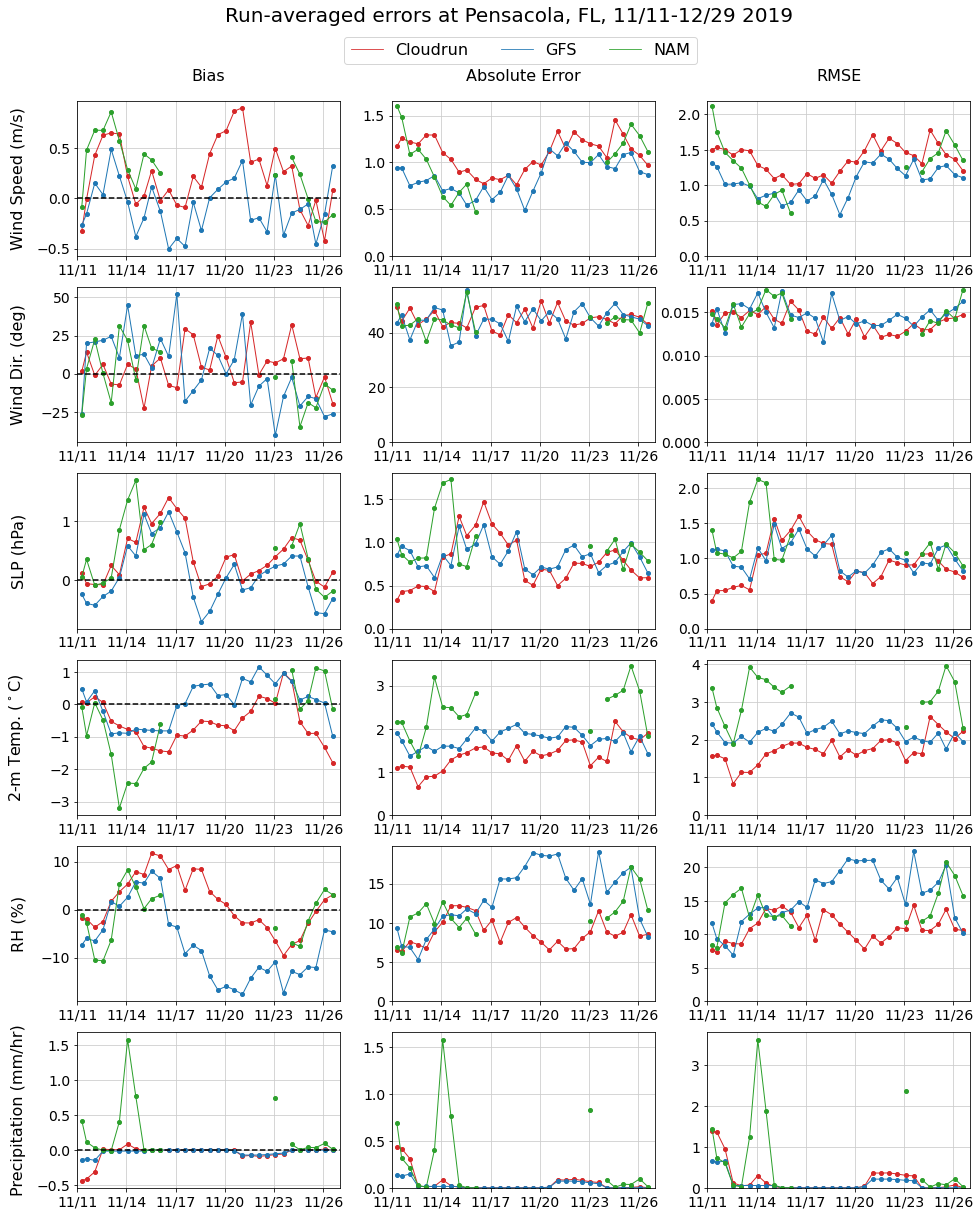

In [26]:
xmin = datetime(2019, 11, 11)
xmax = datetime(2019, 11, 27)

fig, axes = plt.subplots(6, 3, figsize = (16, 20))                                                                        ## set amount of subplots (rows, cols) and figure size
myFmt = mdates.DateFormatter('%m/%d')  

for column in range(len(axes)):
    for row in range(len(axes[column])):
                
        axes[column][row].plot(cr_obs_init_all[variables[column]][sub_keys[row]][0], cr_obs_init_all[variables[column]][sub_keys[row]][1],
                               lw=1, marker='o', ms=4, color='tab:red', label='Cloudrun' if i==0 else None)
        
        axes[column][row].plot(cr_obs_init_all[variables[column]][sub_keys[row]][0], cr_gfs_init_all[variables[column]][sub_keys[row]][1],
                               lw=1, marker='o', ms=4, color='tab:blue', label='GFS' if i==0 else None)

        new_nam_x, new_nam_y = gen_masked_vals(cr_obs_init_all[variables[column]][sub_keys[row]], cr_nam_init_all[variables[column]][sub_keys[row]])
        axes[column][row].plot(new_nam_x, new_nam_y, lw=1, marker='o', ms=4, color='tab:green', label='NAM' if i==0 else None)

        axes[column][row].xaxis.set_major_formatter(myFmt)
        axes[column][row].grid(c='0.8')
        axes[column][row].xaxis.set_major_locator(plt.MaxNLocator(6))
        axes[column][row].tick_params(labelsize=14)
        axes[column][row].set_xlim(xmin, xmax)
        
        if column == 0:
            axes[column][row].set_title(titles[row], fontsize=16, pad=20)

        if row == 0:
            axes[column][row].set_ylabel(ylabels[column], fontsize=16, labelpad=10)
            axes[column][row].plot([xmin, xmax], [0, 0], 'k--')
        else:
            axes[column][row].set_ylim(bottom=0)
            
fig.legend(handles, ['Cloudrun', 'GFS', 'NAM'], bbox_to_anchor=(0.51, 0.93), loc='upper center', prop={'size': 16}, ncol = 3);
fig.align_ylabels()  
fig.suptitle('Run-averaged errors at Pensacola, FL, 11/11-12/29 2019', fontsize=20, y=.945)
plt.savefig('cloudrun_error_runs.png', dpi=300, facecolor='white', edgecolor='none', bbox_inches='tight')

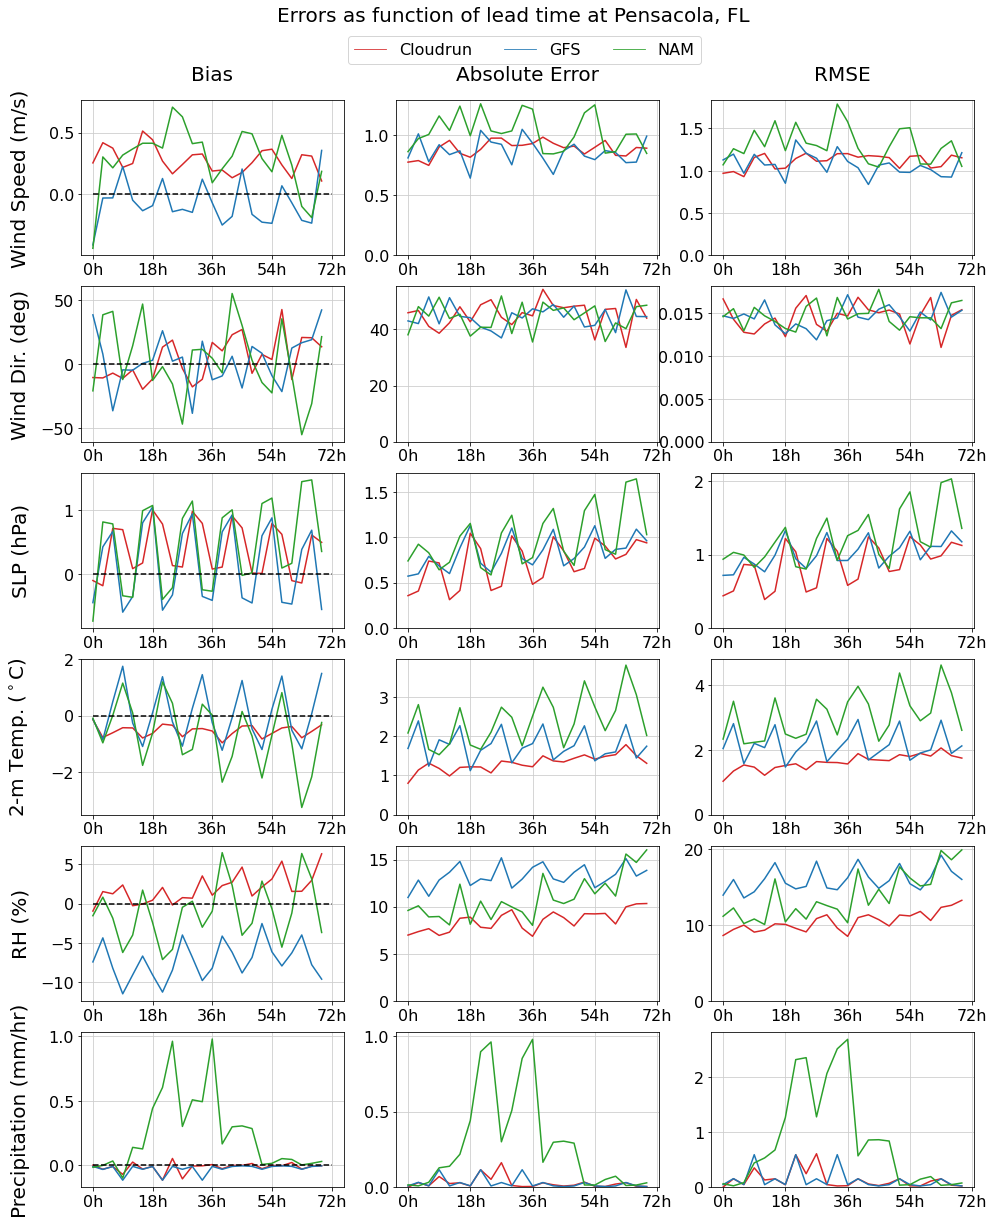

In [27]:
fig, axes = plt.subplots(6,3, figsize = (16, 20))                                                                        ## set amount of subplots (rows, cols) and figure size  

for column in range(len(axes)):
    for row in range(len(axes[row])):
                
        axes[column][row].plot(cr_obs_lead_out[variables[column]][sub_keys[row]][:-1], color='tab:red', label = 'Cloudrun' if i==0 else None)
        axes[column][row].plot(cr_gfs_lead_out[variables[column]][sub_keys[row]][:-1], color='tab:blue', label = 'GFS' if i==0 else None)
        axes[column][row].plot(cr_nam_lead_out[variables[column]][sub_keys[row]][:-1], color='tab:green', label = 'NAM' if i==0 else None)
                
        axes[column][row].grid(c = '0.8')
        axes[column][row].set_xticks(np.arange(0, 30, 6))
        axes[column][row].set_xticklabels(['0h', '18h', '36h', '54h','72h'])
        axes[column][row].tick_params(labelsize=16)

        if column == 0:
            axes[column][row].set_title(titles[row], fontsize=20, pad=20)
            
        if row == 0:            
            axes[column][row].set_ylabel(ylabels[column], fontsize=20, labelpad=10)
            axes[column][row].plot([0, 24], [0, 0], 'k--')
        else:
            axes[column][row].set_ylim(bottom=0)

fig.legend(handles, ['Cloudrun', 'GFS', 'NAM'],bbox_to_anchor=(0.51, 0.93), loc = 'upper center', prop={'size': 16}, ncol = 3);
fig.align_ylabels()  
fig.suptitle('Errors as function of lead time at Pensacola, FL', fontsize=20, y=.945)
plt.savefig('cloudrun_error_lead.png', dpi=300, facecolor='white', edgecolor='none', bbox_inches='tight')

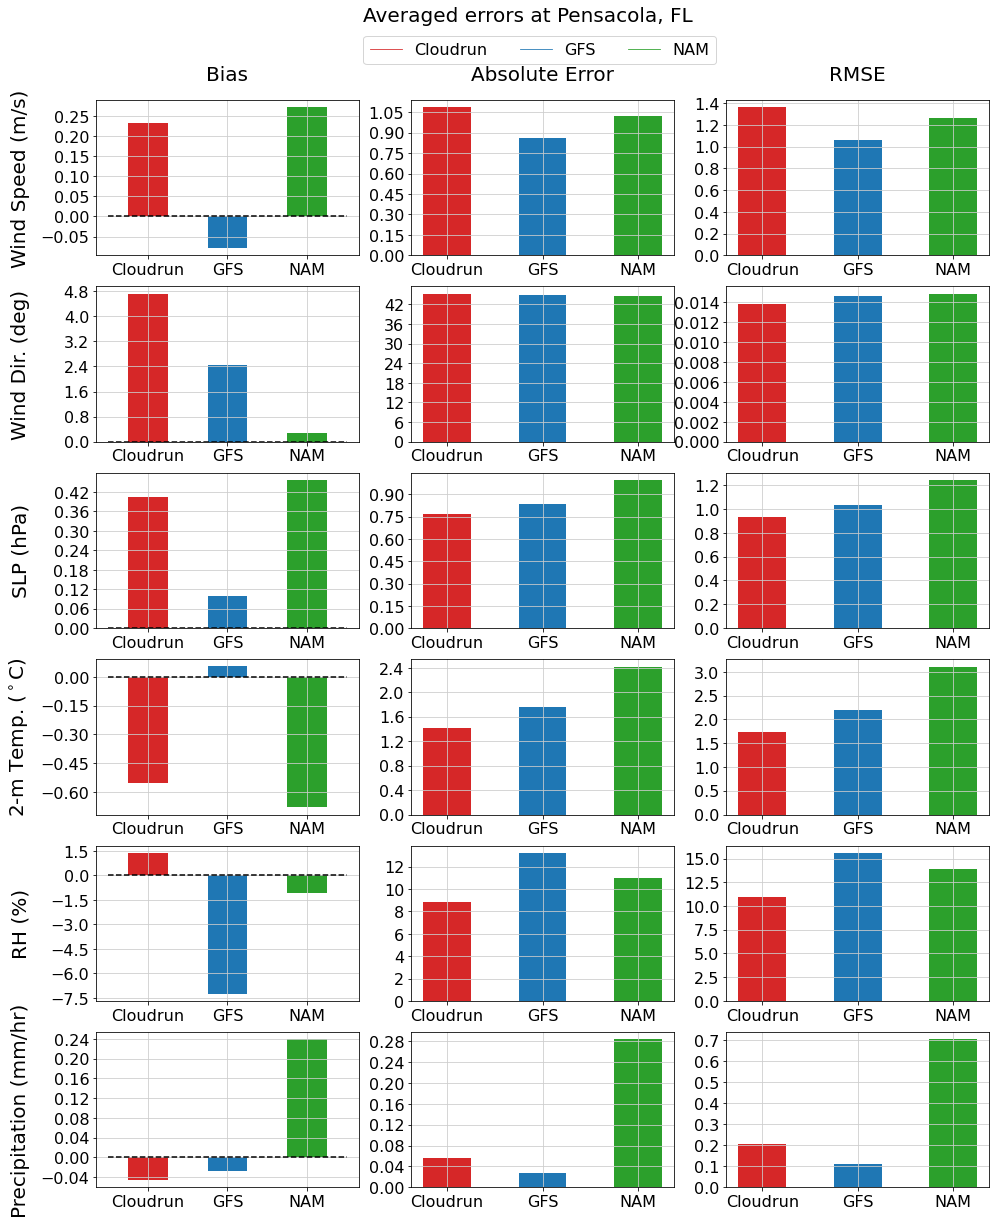

In [28]:
fig, axes = plt.subplots(6, 3, figsize=(16, 20))
x = ['Cloudrun', 'GFS', 'NAM']

for column in range(len(axes)):
    for row in range(len(axes[row])):
        
        axes[column][row].grid(c='0.8')

        vals = [cr_obs_init_avg[variables[column]][sub_keys[row]], cr_gfs_init_avg[variables[column]][sub_keys[row]], cr_nam_init_avg[variables[column]][sub_keys[row]]]
                
        axes[column][row].bar(x, vals, color=('tab:red', 'tab:blue', 'tab:green'), width=0.5)
        
        if column == 0:
            axes[column][row].set_title(titles[row], fontsize=20, pad=20)
            
        if row == 0:            
            axes[column][row].set_ylabel(ylabels[column], fontsize=20, labelpad=10)
            axes[column][row].plot([-0.5, 2.5], [0, 0], 'k--')

        axes[column][row].tick_params(labelsize=16)
        axes[column][row].yaxis.set_major_locator(plt.MaxNLocator(8))

fig.legend(handles, ['Cloudrun', 'GFS', 'NAM'],bbox_to_anchor=(0.51, 0.93), loc='upper center', prop={'size': 16}, ncol=3)
fig.align_ylabels()  
fig.suptitle('Averaged errors at Pensacola, FL', fontsize=20, y=.945)
plt.savefig('cloudrun_pensacola_errorbar.png', dpi=300, facecolor='white', edgecolor='none', bbox_inches='tight')